In [1]:
from ReadCameraModel import ReadCameraModel
from UndistortImage import UndistortImage
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


In [2]:
fx, fy, cx, cy, _, LUT = ReadCameraModel('./Oxford_dataset_reduced/model')

K = [[fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]]
K = np.array(K)

In [75]:
images = []
for file in os.listdir('./Oxford_dataset_reduced/images'):
    img = cv2.imread(os.path.join('./Oxford_dataset_reduced/images', file), 0)
    color_image = cv2.cvtColor(img, cv2.COLOR_BayerGR2BGR)
    undistorted_image = UndistortImage(color_image,LUT)
    images.append(color_image)


In [76]:
img_keys = []
img_desc = []

detector = cv2.xfeatures2d.SIFT_create()

for idx, img in enumerate(images):
    kp1, des1 = detector.detectAndCompute(img, None)
    img_keys.append(kp1)
    img_desc.append(des1)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
image_matches = []
for idx, des in enumerate(img_desc):
    if idx < len(img_desc) - 1:
        matches = bf.match(img_desc[idx], img_desc[idx + 1])
        matches = sorted(matches, key = lambda x:x.distance)
        matches = matches[0:200]
        pts1 = []
        pts2 = []
        idxs =  matches[1:200]
        for i in idxs:
            pts1.append(img_keys[idx][i.queryIdx].pt)
            pts2.append(img_keys[idx+1][i.trainIdx].pt)
        image_matches.append([np.array(pts1), np.array(pts2)])

[array([[  8.,  34.,  95., ...,   0.,  20., 133.],
       [  6.,   0.,   0., ...,   1.,   2.,   9.],
       [118.,  57.,   8., ...,  14.,   1.,   1.],
       ...,
       [ 24.,   6.,   3., ...,   0.,   0.,   0.],
       [ 23.,   3.,   0., ...,   0.,   0.,   0.],
       [ 42.,   2.,   2., ...,   0.,   0.,   0.]], dtype=float32), array([[  0.,   0.,   0., ...,   2.,   0.,   0.],
       [ 13.,   4.,   4., ...,   0.,   0.,   0.],
       [103.,   6.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   3.,  39.],
       [  1.,   0.,   0., ...,   0.,   0.,   2.],
       [  5.,   8.,   2., ...,   0.,   0.,   0.]], dtype=float32), array([[  2.,   3.,   0., ...,   0.,   0.,  18.],
       [  1.,   4.,  16., ...,   6.,  57., 100.],
       [  4.,  34.,  25., ...,   5.,  59.,  52.],
       ...,
       [ 13.,  29.,  21., ...,  27.,  51.,  12.],
       [ 24.,  77.,  18., ...,   2.,   1.,   0.],
       [  9.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), array([[ 70.

In [77]:
fund = []
essential = []
for idx, key in enumerate(image_matches):
    F, mask = cv2.findFundamentalMat(key[0], key[1], cv2.FM_RANSAC)
    fund.append(F)

In [78]:
K_T = np.transpose(K)

essential = []
for fnd in fund:
    essential.append(np.matmul(np.matmul(K_T, fnd), K))
    

In [79]:

R = []
T = []
for idx, e in enumerate(essential):
    pts, r, t, mask = cv2.recoverPose(e, image_matches[idx][0], image_matches[idx][1], cameraMatrix=K)
    R.append(r)
    T.append(t)

In [80]:
rotation_m = []
bot = [0, 0, 0, 1]
for idx, r in enumerate(R):
    half = np.hstack((r, T[idx]))
    full = np.vstack((half, bot))
    rotation_m.append(full)

In [81]:
coords = []
for i in range(len(rotation_m)):
    start = [[0],[0],[0],[1]]
    for j in reversed(range(i)):
        start = np.linalg.inv(rotation_m[j]) @ start
    coords.append(start)

In [83]:
x= []
y= []
z= []

for c in coords:
    x.append(c[0][0])
    y.append(c[1][0])
    z.append(c[2][0])

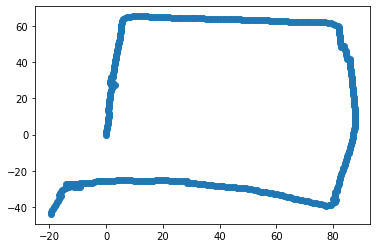

In [84]:
plt.scatter(x,z)
plt.show()

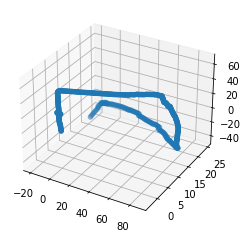

In [85]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x, y, z, cmap='Greens');
